# Overall model evaluation
*This evaluation is carried out by sequantially testing the binary and multiclass classifiers. Only the true positive are passed to the second one.* 

## Library Declaration

In [1]:
import pandas as pd
import joblib
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import TextPreprocessor

## Sequential Classification and Confusion Matirx

=== Classification Report: Binary ===
                   precision    recall  f1-score   support

not_cyberbullying       0.46      0.74      0.57      1589
    cyberbullying       0.94      0.83      0.88      7950

         accuracy                           0.81      9539
        macro avg       0.70      0.78      0.72      9539
     weighted avg       0.86      0.81      0.83      9539

=== Confusion Matrix: Binary ===


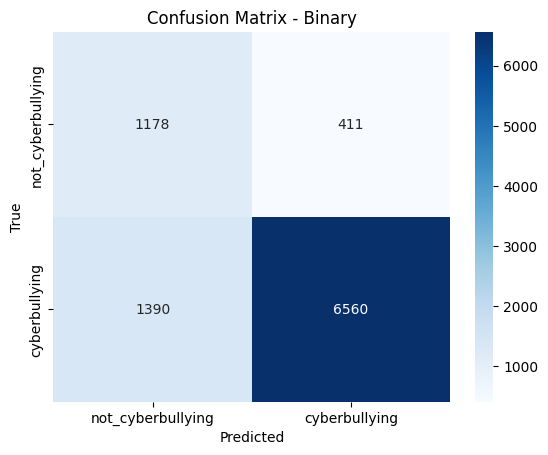

=== Classification Report: Multiclass (only true positives) ===
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1529
         1.0       0.99      0.98      0.99      1575
         2.0       0.94      0.94      0.94      1365
         3.0       0.81      0.86      0.83       604
         4.0       0.99      0.98      0.99      1487

    accuracy                           0.96      6560
   macro avg       0.95      0.95      0.95      6560
weighted avg       0.96      0.96      0.96      6560

=== Confusion Matrix: Multiclass (only true positives) ===


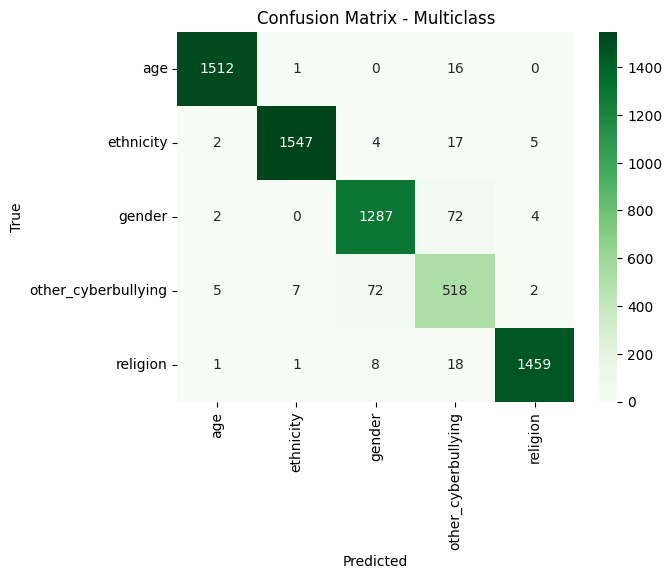

=== Overall Accuracy (binary + multiclass chaining) ===
Correct: 7501 over 9539 = 0.7864


In [2]:
# === Load datasets ===
df_test = pd.read_csv("../dataset/test_set.csv")
X_test_text = df_test["text"]
df_train = pd.read_csv("../dataset/training_set.csv")
df_filtered = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()
label2id = {label: idx for idx, label in enumerate(sorted(df_filtered["multiclass_label"].unique()))}

y_test_binary = df_test["binary_label"].map({"cyberbullying": 1, "not_cyberbullying": 0}).values
y_test_multiclass = df_test["multiclass_label"].map(label2id)

# === Load trained pipelines ===
file_binary = "../model/binary/LogisticRegression_BoW.pkl"
file_multiclass = "../model/multiclass/RandomForest_TF-IDF_multiclass.pkl"
clf_binary = joblib.load(file_binary)
clf_multiclass = joblib.load(file_multiclass)

# === Prediction: Binary ===
y_pred_binary = clf_binary.predict(X_test_text)
print("=== Classification Report: Binary ===")
print(classification_report(y_test_binary, y_pred_binary, target_names=["not_cyberbullying", "cyberbullying"]))

print("=== Confusion Matrix: Binary ===")
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=["not_cyberbullying", "cyberbullying"],
            yticklabels=["not_cyberbullying", "cyberbullying"])
plt.title("Confusion Matrix - Binary")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === Prediction: Multiclass on TP ===
true_positive_mask = (y_test_binary == 1) & (y_pred_binary == 1)
X_test_text_tp = X_test_text[true_positive_mask]
y_test_multiclass_tp = y_test_multiclass[true_positive_mask]
y_pred_multiclass = clf_multiclass.predict(X_test_text_tp)

print("=== Classification Report: Multiclass (only true positives) ===")
print(classification_report(y_test_multiclass_tp, y_pred_multiclass))

print("=== Confusion Matrix: Multiclass (only true positives) ===")
cm_multi = confusion_matrix(y_test_multiclass_tp, y_pred_multiclass)
labels_multi = ["age", "ethnicity", "gender", "other_cyberbullying", "religion"]
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels_multi, yticklabels=labels_multi)
plt.title("Confusion Matrix - Multiclass")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# === Overall system accuracy ===
true_negative = ((y_test_binary == 0) & (y_pred_binary == 0)).sum()
true_positive_multiclass = (y_pred_multiclass == y_test_multiclass_tp).sum()
total_test_samples = len(y_test_binary)
overall_correct = true_negative + true_positive_multiclass
overall_accuracy = overall_correct / total_test_samples

print(f"=== Overall Accuracy (binary + multiclass chaining) ===")
print(f"Correct: {overall_correct} over {total_test_samples} = {overall_accuracy:.4f}")


## True Positive Dataset Saving

In [3]:
true_positives = df_test[true_positive_mask]
true_positives.to_csv("../dataset/true_positive.csv", index=False)